In [1]:
from numpy.random import seed
seed(101)
from tensorflow import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


In [2]:
base_dir = r'C:\Users\PURNA KOSSAMBE\Desktop\Project1\base_dir'
os.mkdir(base_dir)


In [3]:
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)
melanoma = os.path.join(train_dir, 'melanoma')
os.mkdir(melanoma)
notMelanoma = os.path.join(train_dir, 'notMelanoma')
os.mkdir(notMelanoma)
melanoma = os.path.join(val_dir, 'melanoma')
os.mkdir(melanoma)
notMelanoma = os.path.join(val_dir, 'notMelanoma')
os.mkdir(notMelanoma)

In [5]:
print(len(os.listdir(r'base_dir\train_dir\melanoma')))
print(len(os.listdir(r'base_dir\train_dir\notMelanoma')))

12032
12032


In [7]:
print(len(os.listdir(r'base_dir\val_dir\melanoma')))
print(len(os.listdir(r'base_dir\val_dir\notMelanoma')))

516
434


In [8]:
train_path = r'base_dir\train_dir'
valid_path = r'base_dir\val_dir'

num_train_samples = len(os.listdir(r'base_dir\train_dir'))
num_val_samples = len(os.listdir(r'base_dir\val_dir'))
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [9]:
train_batches = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                                    train_path,
                                                    target_size=(image_size,image_size),
                                                    batch_size=train_batch_size)
valid_batches = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                                    valid_path,
                                                    target_size=(image_size,image_size),
                                                    batch_size=val_batch_size)


test_batches = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                                    valid_path,
                                                    target_size=(image_size,image_size),
                                                    batch_size=val_batch_size,
                                                    shuffle=False)

Found 24064 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 950 images belonging to 2 classes.


In [10]:
mobile = keras.applications.mobilenet.MobileNet()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
mobile.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [64]:
x = mobile.layers[-6].output



x = Dropout(0.25)(x)
predictions = Dense(2, activation='softmax')(x)


model = Model(inputs=mobile.input, outputs=predictions)

In [65]:
for layer in model.layers[:-48]:
    layer.trainable = False

In [66]:
from tensorflow.keras.metrics import categorical_accuracy
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy])

In [67]:
print(valid_batches.class_indices)

{'melanoma': 0, 'notMelanoma': 1}


In [68]:
class_weights={
    0: 1.0, 
    1: 1.0, 
    }

In [69]:
filepath = r"\Project1\modelraw.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/20
1/1 [==============================] - 87s 87s/step - loss: 1.4231 - categorical_accuracy: 0.3000 - val_loss: 6.4472 - val_categorical_accuracy: 0.6000

Epoch 00001: val_categorical_accuracy improved from -inf to 0.60000, saving model to C:\Users\PURNA KOSSAMBE\Desktop\Project1\modelraw.h5
Epoch 2/20
1/1 [==============================] - 10s 10s/step - loss: 4.8354 - categorical_accuracy: 0.7000 - val_loss: 11.2827 - val_categorical_accuracy: 0.3000

Epoch 00002: val_categorical_accuracy did not improve from 0.60000
Epoch 3/20
1/1 [==============================] - 11s 11s/step - loss: 4.8354 - categorical_accuracy: 0.7000 - val_loss: 1.6118 - val_categorical_accuracy: 0.9000

Epoch 00003: val_categorical_accuracy improved from 0.60000 to 0.90000, saving model to C:\Users\PURNA KOSSAMBE\Desktop\Project1\modelraw.h5
Epoch 4/20
1/1 [==============================] - 10s 10s/step - loss: 9.6709 - categorical_accuracy: 0.4000 - val_loss: 9.6709 - val_categorical_accuracy: 0.400

In [70]:
model.metrics_names

['loss', 'categorical_accuracy']

In [71]:
df_val=os.listdir(r'Cbase_dir\val_dir')
val_loss, val_cat_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)


val_loss: 1.1920928955078125e-07
val_cat_acc: 1.0


<Figure size 432x288 with 0 Axes>

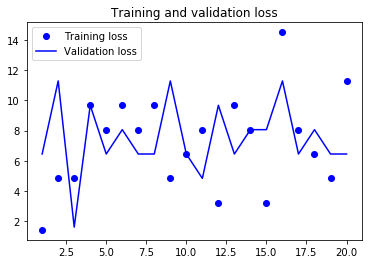

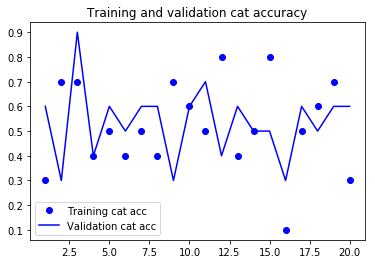

<Figure size 432x288 with 0 Axes>

In [72]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
test_labels = test_batches.classesepochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()



In [74]:
test_labels = test_batches.classes

In [76]:
model.save(r'Cmodels\melnotmel.model')

In [77]:
from keras import backend as K
K.set_learning_phase(0)

In [79]:
from keras.models import load_model
model= load_model(r'Project1\modelraw.h5')
print (model.outputs)
print(model.inputs)

[<tf.Tensor 'dense_2_1/Softmax:0' shape=(?, 2) dtype=float32>]
[<tf.Tensor 'input_1_4:0' shape=(?, 224, 224, 3) dtype=float32>]


In [80]:
from keras import backend as K
import tensorflow as tf
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph=session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names+= [v.op.name for v in tf.global_variables()]
        input_graph_def= graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device=""
        frozen_graph=convert_variables_to_constants(session,input_graph_defination,output_names,freeze_var_names)
        return frozen_graph
from keras import backend as K
model= r"Desktop\Project1\modelraw.h5"
frozen_graph= freeze_session(K.get_session(),output_names= [out.op.name for out in model.outputs])
tf.train.write_graph(frozen_graph,wkdir,pb_filename, as_text= False)


AttributeError: 'str' object has no attribute 'outputs'